In [1]:
import os
import glob
import pandas as pd
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Flip_dataframes(df):
    """Process the dataframe: Remove negative x values, normalize x, and make negative values positive."""
    df = df[df['x'] >= 0].copy()
    first_x_value = df['x'].iloc[0]
    df['x'] = df['x'] - first_x_value
    df['x'] = df['x'].abs()
    
    return df

def Merging(df_begin, df_middle, df_end, particle_folder):
    """Merging of the dataframes of the different parts of the trajectory of each particle"""
    df_middle = df_middle.drop(index=0).reset_index(drop=True)
    last_x_value_df_begin = df_begin['x'].iloc[-1]
    df_middle['x'] = df_middle['x'] + last_x_value_df_begin
    
    # this line gives a warning if the 'jump' in y values becomes to high
    if df_middle['y'].iloc[0] - df_begin['y'].iloc[-1] >= 0.05:
        print(f'WARNING: there is a jump in y-values larger that 2 cm between dataframes beginning and middle for {particle_folder}')
        print(f"The difference is equal to {(df_middle['y'].iloc[0] - df_begin['y'].iloc[-1])} m")
        
        
    df_begin['t'] = df_begin['t'] -  df_begin['t'].iloc[0]
    delta_t = df_begin['t'].iloc[1] - df_begin['t'].iloc[0]
    df_middle['t'] = df_middle['t'] + df_begin['t'].iloc[-1] + delta_t - df_middle['t'].iloc[0]
    merged_df_beginmiddle = pd.concat([df_begin, df_middle], ignore_index=True)
    
    
        
    df_end = df_end.drop(index=0).reset_index(drop=True)
    last_x_value_df_merged_beginmiddle = merged_df_beginmiddle['x'].iloc[-1]
    df_end['x'] = df_end['x'] + last_x_value_df_merged_beginmiddle
    
    # this line gives a warning if the 'jump' in y values becomes to high
    if abs(df_end['y'].iloc[0] - merged_df_beginmiddle['y'].iloc[-1]) >= 0.05:
        print(f'WARNING: there is a jump in y-values larger that 2 cm between dataframes middle and end for {particle_folder}')
        print(f"The difference is equal to {(df_end['y'].iloc[0] - merged_df_beginmiddle['y'].iloc[-1])} m")

    delta_t_2 = merged_df_beginmiddle['t'].iloc[1] - merged_df_beginmiddle['t'].iloc[0]
    df_end['t'] = df_end['t'] + merged_df_beginmiddle['t'].iloc[-1] + delta_t_2 - df_end['t'].iloc[0]
    merged_df = pd.concat([merged_df_beginmiddle, df_end], ignore_index=True)

    return merged_df


In [3]:
# Store merged dataframes for each folder with file name information
merged_data_dict = {}

# Base directory where all the runs are located
base_dir = 'C:/Users/lswus/Documents/A_MasterThesis/Trajectory_data_test'

# Loop over each run (R1, R2, R3, etc.)
for run_folder in os.listdir(base_dir):
    run_path = os.path.join(base_dir, run_folder)
    
    if os.path.isdir(run_path) and run_folder.startswith('R'):
        for particle_folder in os.listdir(run_path):
            particle_path = os.path.join(run_path, particle_folder)
            
            if os.path.isdir(particle_path) and "_" in particle_folder and particle_folder.split("_")[1].startswith('P'):
                file_path_begin, file_path_middle, file_path_end = None, None, None

                # Loop through the parts (begin, middle, end)
                for part in ['B', 'M', 'E']:
                    file_pattern = os.path.join(particle_path, f'{particle_folder}_*_{part}.txt')
                    file_paths = glob.glob(file_pattern)
                    
                    if part == 'B' and file_paths:
                        file_path_begin = file_paths[0]
                    elif part == 'M' and file_paths:
                        file_path_middle = file_paths[0]
                        # print(file_path_middle)
                    elif part == 'E' and file_paths:
                        file_path_end = file_paths[0]

                # Read and process the files
                if file_path_begin and file_path_middle and file_path_end:
                    df_begin = pd.read_csv(file_path_begin, delimiter='\t', skiprows=1)
                    df_middle = pd.read_csv(file_path_middle, delimiter='\t', skiprows=1)
                    df_end = pd.read_csv(file_path_end, delimiter='\t', skiprows=1)

                    df_begin = Flip_dataframes(df_begin)
                    df_middle = Flip_dataframes(df_middle)
                    df_end = Flip_dataframes(df_end)

                    merged_df = Merging(df_begin, df_middle, df_end, particle_folder)

                    # Extract part of the filename
                    common_prefix = "_".join(file_path_begin.split("\\")[-1].split("_")[:-1])

                    # Store in dictionary with descriptive key
                    merged_data_dict[f'{common_prefix}'] = merged_df

# Display dictionary keys
print(f"Total merged datasets: {len(merged_data_dict)}")


The difference is equal to 0.07008329032153524 m
The difference is equal to 0.12032706786330133 m
The difference is equal to 0.07506271091052671 m
The difference is equal to 0.06414062780000596 m
The difference is equal to 0.07149566725292389 m
The difference is equal to 0.055005954769604015 m
The difference is equal to 0.06458783123276698 m
The difference is equal to 0.09262951563860461 m
Total merged datasets: 44


In [4]:
# Choose the key corresponding to the dataframe you want to save
selected_key = 'R1_P1_3'  # Example: replace with the actual key you want
selected_df = merged_data_dict[selected_key]
output_file_path = 'C:/Users/lswus/Documents/A_MasterThesis/Trajectory_data/R1/R1_P1/Test_txtfileR1_P1'

# Save the selected dataframe as a tab-delimited .txt file
selected_df.to_csv(output_file_path, sep='\t', index=False)

print(f"Dataframe saved to: {output_file_path}")


Dataframe saved to: C:/Users/lswus/Documents/A_MasterThesis/Trajectory_data/R1/R1_P1/Test_txtfileR1_P1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


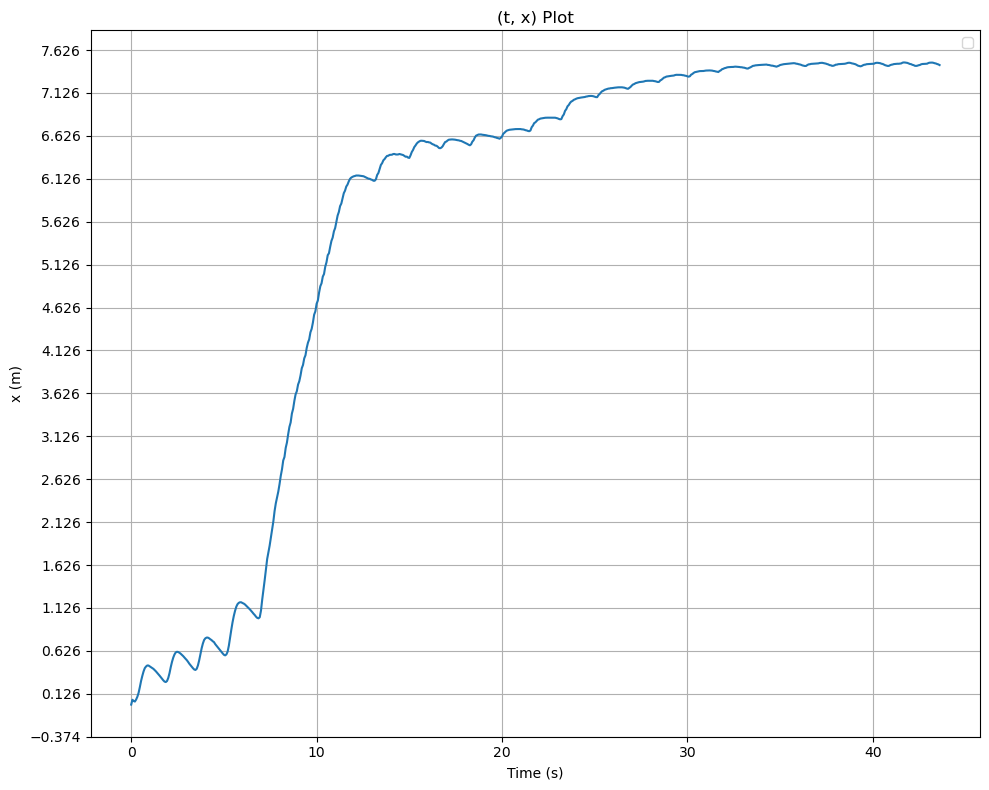

In [5]:

plt.figure(figsize=(10, 8))

# Subplot 1: (t, x) plot
df = merged_data_dict['R1_P1_3']
plt.plot(df['t'], df['x'])
plt.xlabel('Time (s)')
plt.ylabel('x (m)')
plt.title('(t, x) Plot')

y_min, y_max = plt.ylim()  # Get the current y-axis limits
y_ticks = np.arange(y_min, y_max, 0.5)  # Adjust 0.1 to the desired step size
plt.yticks(y_ticks)


plt.legend()
plt.grid('both')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [6]:
# # Filter the keys that end with '_3'
# selected_keys = [key for key in merged_data_dict.keys() if key.endswith('_7')]
# print(selected_keys)

# # # Create a figure with subplots
# plt.figure(figsize=(10, 8))

# # Subplot 1: (t, x) plot
# plt.subplot(3, 1, 1)
# for key in selected_keys:
#     df = merged_data_dict[key]
#     plt.plot(df['t'], df['x'], label=f"{key}")
# plt.xlabel('Time (s)')
# plt.ylabel('x (m)')
# plt.title('(t, x) Plot')
# # plt.legend()
# plt.grid(True)

# # Subplot 2: (t, y) plot
# plt.subplot(3, 1, 2)
# for key in selected_keys:
#     df = merged_data_dict[key]
#     plt.plot(df['t'], df['y'], label=f"{key}")
# plt.xlabel('Time (s)')
# plt.ylabel('y (m)')
# plt.title('(t, y) Plot')
# plt.ylim(0, 0.8)
# # plt.legend()
# plt.grid(True)

# # Subplot 3: (x, y) plot
# plt.subplot(3, 1, 3)
# for key in selected_keys:
#     df = merged_data_dict[key]
#     plt.plot(df['x'], df['y'], label=f"{key}")
#     plt.plot(df['x'].iloc[0], df['y'].iloc[0], 'g.') #, label=f"{key} start"
#     plt.plot(df['x'].iloc[-1], df['y'].iloc[-1], 'r.') # , label=f"{key} end"

# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.title('(x, y) Plot')
# plt.ylim(0, 0.8)
# # plt.legend()
# plt.grid(True)

# # Adjust layout and show the plots
# plt.tight_layout()
# plt.show()
